In [1]:
import os
import csv
import shapefile
import pysal
import pandas as pd

/opt/conda/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Set and check the data path

In [3]:
data_dir = os.path.abspath('Data')
geom_file = os.path.join(data_dir, 'NYC_sample_geometries.csv')
flow_file = os.path.join(data_dir, 'NYC_sample_flow.csv')

if os.path.exists(geom_file):
    print('Input file:', geom_file, flow_file)
else:
    print('Data directory is:', data_dir)
    print('Please fix the path!')

Input file: /home/project/NYC-hexagon-outlier-detection/Data/NYC_sample_geometries.csv /home/project/NYC-hexagon-outlier-detection/Data/NYC_sample_flow.csv


# 1. Create the shapefile
reference: http://geospatialpython.com/2015/08/csv-to-shapefile.html

In [4]:
# Create a polygon shapefile writer
wrt = shapefile.Writer(shapefile.POLYGON)

In [5]:
# Add fields
wrt.field('AreaId', 'N', 6, 0)

In [6]:
# Open the csv file and set up a reader
with open(geom_file) as p:
    reader = csv.DictReader(p)
    for row in reader:
        # Add records for each polygon
        wrt.record(row['AreaId'])
        # Parse the coordinate string
        wkt = row['Geometry'][15:-3]
        # Break the coordinate string into x,y coordinates
        coords = wkt.split(",")
        # Set up a list to contain the coordinates for each node
        part = []
        # Convert the x,y values to floats
        for c in coords:
            x,y = c.split(' ')
            part.append([float(x), float(y)])
        # Create a polygon record with the list of coordinates
        wrt.poly(parts=[part])

In [7]:
# Save the shapefile
wrt.save('NYC_sample_hexagons.shp')

# 2. Create the neighbor list
For each AreaId, detect its neighbors, i.e. the polygons that share a common edge. 

In [8]:
nb = pysal.rook_from_shapefile('NYC_sample_hexagons.shp', 'AreaId')

In [9]:
type(nb.neighbors)

dict

In [10]:
hist = pd.DataFrame(nb.histogram, columns=['bin', 'cnt'])

<BarContainer object of 5 artists>

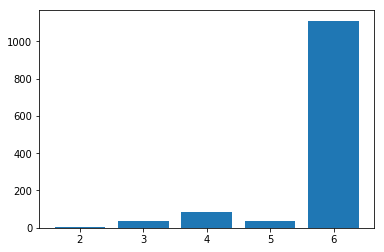

In [11]:
plt.bar(hist.bin,hist.cnt)

# 3. Final output 

In [12]:
# Read in nyc_flow.csv and pivot the table
flow = pd.read_csv(flow_file)

In [13]:
areaIds = list(set(flow.AreaId)) # iterate through a list is faster than through a set

In [14]:
flow = flow.set_index(['AreaId', 'StartTime'])

In [15]:
flow.head()

NewCount
AreaId StartTime                    
229777 2015-09-01 00:00:00       304
       2015-09-01 01:00:00       100
       2015-09-01 02:00:00        52
       2015-09-01 03:00:00       304
       2015-09-01 04:00:00       248

In [16]:
all_neighbors_mean_counts = pd.DataFrame()
for areaId in areaIds:
    neighbors = set(nb.neighbors[areaId])
    neighbors_df = flow[flow.index.isin(neighbors, level='AreaId')]
    neighbors_mean_count = neighbors_df.mean(level='StartTime').reset_index()
    neighbors_mean_count['AreaId'] = areaId
    all_neighbors_mean_counts = all_neighbors_mean_counts.append(neighbors_mean_count)

In [17]:
all_neighbors_mean_counts.rename(columns={'NewCount':'Average'}, inplace=True)

In [18]:
all_neighbors_mean_counts = all_neighbors_mean_counts.set_index(['AreaId', 'StartTime'])

In [19]:
count_difference = flow.join(all_neighbors_mean_counts)
count_difference['Diff'] = count_difference.NewCount - count_difference.Average 

In [20]:
count_difference.head()

NewCount  Average   Diff
AreaId StartTime                                    
229777 2015-09-01 00:00:00       304    252.5   51.5
       2015-09-01 01:00:00       100    393.5 -293.5
       2015-09-01 02:00:00        52     44.0    8.0
       2015-09-01 03:00:00       304    165.5  138.5
       2015-09-01 04:00:00       248    346.5  -98.5

In [21]:
count_difference.to_csv('NYC_sample_difference.csv')

# 4. Outlier Detection

In [22]:
# count_difference = pd.read_csv('NYC_sample_difference.csv')
nyc_pivot = count_difference.reset_index().pivot(index='AreaId', columns='StartTime', values='NewCount')
nyc_pivot.fillna(value=0, inplace=True)

In [23]:
nyc_pivot.head()

StartTime,2015-09-01 00:00:00,2015-09-01 01:00:00,2015-09-01 02:00:00,2015-09-01 03:00:00,2015-09-01 04:00:00,2015-09-01 05:00:00,2015-09-01 06:00:00,2015-09-01 07:00:00,2015-09-01 08:00:00,2015-09-01 09:00:00,...,2015-09-07 14:00:00,2015-09-07 15:00:00,2015-09-07 16:00:00,2015-09-07 17:00:00,2015-09-07 18:00:00,2015-09-07 19:00:00,2015-09-07 20:00:00,2015-09-07 21:00:00,2015-09-07 22:00:00,2015-09-07 23:00:00
AreaId,,,,,,,,,,,,,,,,,,,,,
229777,304.0,100.0,52.0,304.0,248.0,133.0,261.0,444.0,466.0,393.0,...,438.0,19.0,60.0,295.0,397.0,5.0,194.0,241.0,134.0,391.0
229778,358.0,457.0,49.0,85.0,258.0,475.0,110.0,454.0,7.0,176.0,...,19.0,418.0,230.0,347.0,231.0,70.0,385.0,38.0,474.0,252.0
229779,399.0,204.0,274.0,274.0,473.0,215.0,86.0,44.0,258.0,56.0,...,408.0,306.0,142.0,243.0,133.0,171.0,402.0,409.0,459.0,183.0
229780,401.0,97.0,117.0,286.0,149.0,401.0,377.0,48.0,95.0,73.0,...,306.0,478.0,178.0,193.0,197.0,420.0,215.0,171.0,38.0,232.0
229781,169.0,217.0,26.0,260.0,499.0,365.0,188.0,126.0,27.0,123.0,...,261.0,21.0,156.0,333.0,188.0,35.0,281.0,167.0,168.0,252.0


In [24]:
from sklearn.cluster import AgglomerativeClustering

In [25]:
ward = AgglomerativeClustering(n_clusters=2, linkage='ward').fit(nyc_pivot)
labels=ward.labels_

In [26]:
# Number of clusters in labels
n_clusters_ = len(set(labels)) 
print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


In [28]:
import numpy as np
unique, counts = np.unique(labels, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0    5]
 [   1 1091]]


In [29]:
nyc_pivot['labels'] = labels

In [30]:
nyc_pivot[nyc_pivot['labels']==0]

StartTime,2015-09-01 00:00:00,2015-09-01 01:00:00,2015-09-01 02:00:00,2015-09-01 03:00:00,2015-09-01 04:00:00,2015-09-01 05:00:00,2015-09-01 06:00:00,2015-09-01 07:00:00,2015-09-01 08:00:00,2015-09-01 09:00:00,...,2015-09-07 15:00:00,2015-09-07 16:00:00,2015-09-07 17:00:00,2015-09-07 18:00:00,2015-09-07 19:00:00,2015-09-07 20:00:00,2015-09-07 21:00:00,2015-09-07 22:00:00,2015-09-07 23:00:00,labels
AreaId,,,,,,,,,,,,,,,,,,,,,
229784,3507.0,2515.0,4574.0,3457.0,3954.0,1879.0,4046.0,2977.0,1757.0,3637.0,...,3470.0,4768.0,2095.0,2410.0,1490.0,2246.0,1322.0,1956.0,4925.0,0
231460,1897.0,2001.0,2370.0,1665.0,3569.0,1047.0,3131.0,2414.0,3546.0,4826.0,...,1131.0,1575.0,1568.0,1234.0,3662.0,2278.0,1682.0,1104.0,4630.0,0
232200,3516.0,3130.0,3058.0,4884.0,2268.0,4615.0,1498.0,4568.0,2805.0,3724.0,...,1751.0,3262.0,3963.0,1944.0,3077.0,3793.0,1626.0,3659.0,1511.0,0
233511,0.0,0.0,4740.0,3005.0,0.0,3747.0,4488.0,1861.0,3440.0,2002.0,...,3045.0,4164.0,2726.0,2589.0,2616.0,3131.0,2872.0,1628.0,4134.0,0
236330,4950.0,3001.0,2094.0,2803.0,2983.0,1560.0,2879.0,2708.0,1485.0,1343.0,...,4517.0,3371.0,4005.0,3401.0,4531.0,1844.0,3299.0,1349.0,4108.0,0


## Recall that the 5 randomly chosen "high flow" hexagons:
high flow ids are:  set([232200, 229784, 236330, 231460, 233511])
## Successfully detected the 5 outliers!

# A little extra: Some Time Series Analysis and Visualization
This is a simple demonstration of Time Series analysis and visualization in python. Since the data is randomly generated, the result may not make much sense.

In [31]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [32]:
count_difference = pd.read_csv('NYC_sample_difference.csv')

In [33]:
TS = count_difference[count_difference['AreaId']==232200]

In [34]:
TS.dtypes

AreaId         int64
StartTime     object
NewCount       int64
Average      float64
Diff         float64
dtype: object

In [35]:
dt_time = pd.to_datetime(TS.loc[:,'StartTime'])
TS.loc[:,'StartTime'] = dt_time

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [36]:
TS = TS.set_index(['StartTime'])

In [37]:
TS.head()

,AreaId,NewCount,Average,Diff
StartTime,,,,
2015-09-01 00:00:00,232200,3516,161.500000,3354.500000
2015-09-01 01:00:00,232200,3130,187.833333,2942.166667
2015-09-01 02:00:00,232200,3058,232.000000,2826.000000
2015-09-01 03:00:00,232200,4884,191.000000,4693.000000
2015-09-01 04:00:00,232200,2268,234.166667,2033.833333


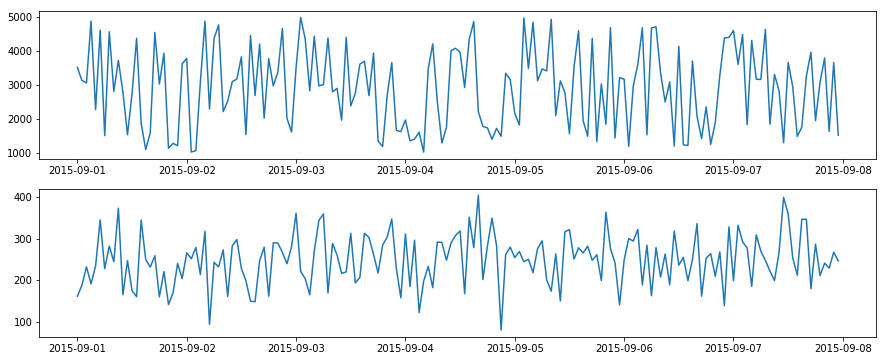

In [38]:
plt.subplot(211)
plt.plot(TS.NewCount, label='Count')
plt.subplot(212)
plt.plot(TS.Average, label='Average Count of Neighbors')

In [39]:
# Perform Dickey-Fuller test 
# Null hypothesis is that the TS is non-stationary. Random data should be stationary. We expect to reject the null hypothesis.
from statsmodels.tsa.stattools import adfuller 

In [42]:
print('Results of Dickey-Fullyer Test:')
dftest = adfuller(TS.NewCount, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'P-Value', 'Number of Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Dickey-Fullyer Test:
Test Statistics               -1.234931e+01
P-Value                        5.874248e-23
Number of Lags Used            0.000000e+00
Number of Observations Used    1.670000e+02
Critical Value (1%)           -3.470126e+00
Critical Value (5%)           -2.879008e+00
Critical Value (10%)          -2.576083e+00
dtype: float64
